In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.regularizers import l1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, concatenate
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pylab as pl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn import preprocessing
import math


# audio lib
import librosa
import librosa.display
from librosa.util import fix_length

import IPython.display as ipd
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings("ignore")

# CNN MEL SPECTROGRAM APPROACH

Dato il risultato non soddisfacente attraverso le features di opensmile si verifica un secondo approccio, ovvero addestrare una rete convoluzionale attraverso le immagini 300x300 di spettrogramma di Mel. Ogni spectrogramma fa riferimento a 6 secondi di canzone. Gli spettrogrammi sono stati generati in precedenza.

In [3]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [4]:
path = '../input/mel-pmemo/melspectrogram_dataset/'

# Load the images and the labels
imgs = []
dirlist = sorted_alphanumeric(os.listdir(path))

for img in dirlist:
    pic = image.load_img((path + img))
    imgs.append(np.array(pic))
    

In [5]:
imgs = np.array(imgs)
imgs.shape

(3743, 300, 300, 3)

In [6]:
df = pd.read_csv('../input/mel-pmemo/mel.csv')
df.head(8)

,ID,Label
0,1-0,1
1,1-1,1
2,1-2,1
3,1-3,1
4,1-4,1
5,4-0,0
6,4-1,0
7,4-2,0


In [7]:
Y = np.array(df['Label'])
Y.shape

(3743,)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(imgs, Y, test_size=0.2)

Si procede a costruire il modello della rete neurale convoluzionale.
si utilizzano i seguenti iperparametri:


*   Tipo di modello: CNN
*   Modello di partenza: EfficientNetB3
*   Numero di epoche 50;
*   Activation Output Layer Softmax: funzione più usata per la classificazione multiclasse;
*   Activation Hidden Layer ReLU: è la funzione di "deafult" grazie alla sua versatilità per la maggior parte degli utilizzi;
*   Loss Function Sparse Categorical Crossentropy: funzione usata nella classificazione multiclasse usando varibili categoriche;
*   Optimizer adam;
*   Regolarizzazione tramite L2 con alpha = 0.1: si limitano le unità con pesi troppo grossi per evitare overfitting e tramite dropout decrescente.
*   Per evitare overfitting si utilizzeranno i pesi che ottengono il miglior valore di accuracy sul validation set.

In [9]:
# Load a pre-trained neural network to use for transfer learning
base_net = keras.applications.EfficientNetB3(
    input_shape=(300,300,3),
    weights='imagenet',
    include_top=False,
    drop_connect_rate=0.4,
    pooling='avg'
)

# Set the layers of the base net to not be trained
for layer in base_net.layers:
  layer.trainable=True

2022-04-30 16:09:15.051102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 16:09:15.161846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 16:09:15.162657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 16:09:15.164133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 0s 0us/step


In [10]:
x = Flatten()(base_net.layers[-1].output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(4, activation='softmax')(x)
outputs = x

OPT = tf.keras.optimizers.Adam()

cnn = keras.Model(inputs=base_net.inputs, outputs=outputs)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=OPT, metrics=['accuracy'])

#cnn.summary()

In [11]:
filepath_cnn="weights.cnn.hdf5"
checkpoint = ModelCheckpoint(filepath_cnn, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [12]:
hist_cnn = cnn.fit(x_train, y_train, epochs=50, validation_split = 0.1,
                   callbacks=[checkpoint])

2022-04-30 16:09:22.079001: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-30 16:09:34.803858: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


85/85 [==============================] - 84s 766ms/step - loss: 0.9460 - accuracy: 0.6570 - val_loss: 0.8474 - val_accuracy: 0.6733

Epoch 00001: val_loss improved from inf to 0.84744, saving model to weights.cnn.hdf5
Epoch 2/50
85/85 [==============================] - 62s 735ms/step - loss: 0.8536 - accuracy: 0.6804 - val_loss: 6.6222 - val_accuracy: 0.6733

Epoch 00002: val_loss did not improve from 0.84744
Epoch 3/50
85/85 [==============================] - 62s 735ms/step - loss: 0.7696 - accuracy: 0.7261 - val_loss: 1.1206 - val_accuracy: 0.5600

Epoch 00003: val_loss did not improve from 0.84744
Epoch 4/50
85/85 [==============================] - 63s 736ms/step - loss: 0.7433 - accuracy: 0.7357 - val_loss: 1.2885 - val_accuracy: 0.6833

Epoch 00004: val_loss did not improve from 0.84744
Epoch 5/50
85/85 [==============================] - 62s 733ms/step - loss: 0.6733 - accuracy: 0.7535 - val_loss: 0.9163 - val_accuracy: 0.7400

Epoch 00005: val_loss did not improve from 0.84744
Ep

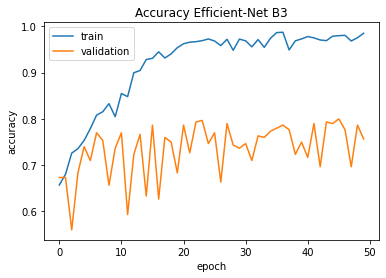

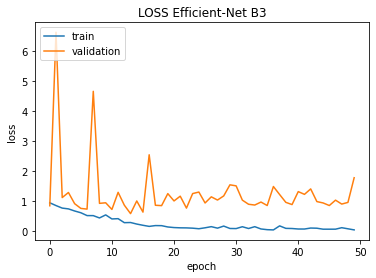

In [13]:
def plot_hist(hist, title):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Accuracy " + title)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


plot_hist(hist_cnn, title="Efficient-Net B3")

In [14]:
test_loss, test_acc = cnn.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

24/24 - 3s - loss: 2.1461 - accuracy: 0.7583

Test accuracy: 0.7583444714546204


I risultati ottenuti sono nettamente migliori, si utilizzerà questo approccio.